# Feature engineering with Granger Causality
Within this notbook a new dataframe will be build with freatures (orignial as well as lagged features) selected by Granger causality with the target variable. Therefore different functions are build to automatically get the p-values for each feature and select this feature for the new dataframe. This new dataframe can than be used for modeling.

## Setup

In [1]:
# Loading packages and their components
import pandas as pd
import numpy as np
import pickle

from statsmodels.tsa.stattools import grangercausalitytests

In [2]:
# Load data
data_subsets_splitted_joined = pickle.load(open('splitted_joined_data.pickle', 'rb'))

sj_train_train, \
sj_train_test, \
sj_test, \
iq_train_train, \
iq_train_test, \
iq_test = data_subsets_splitted_joined

## Functions for lagged features

In [3]:
def get_lagged_dataframe(df, features, max_lag):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags (defined by max_lag) start at 1.
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    max_lag: number of maximum lags
    
    """
    d = {}
    for feature in features:
        for lag in range(1, max_lag+1):
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

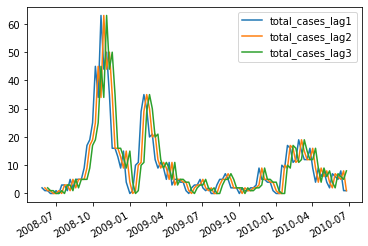

In [4]:
# testing the function
test = get_lagged_dataframe(df=iq_train_test, features=['total_cases'], max_lag=3).plot();

Second function for specific lags (non-continous)

In [5]:
def get_specific_lagged_dataframe(df, features, lags):
    """
    Creates new dataframe with certain lagged features as columns. 
    Number of lags given in lags start at 0, which is the original feature (without shift).
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features: list, of feature names
    lags: list, which contains lags (int), zero for original data will be added in the function
    
    """
    d = {}
    lags.append(0)
    for feature in features:
        for lag in lags:
            l = []
            for r in range(len(df)):
                l.append(df.shift(lag)[feature][r])
            d[f'{feature}_lag{lag}'] = l
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    # delete '_lag0'
    return lagged_df

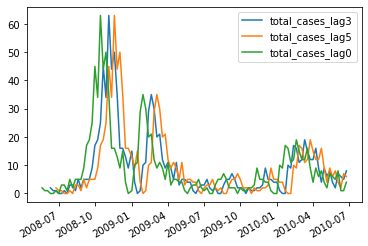

In [6]:
# test the function
get_specific_lagged_dataframe(df=iq_train_test, features=['total_cases'], lags=[3,5]).plot();

### Granger Causality
The Granger causality test is a statistical hypothesis test for determining whether one time series is useful in forecasting another (from [Wikipedia: Granger causality](https://en.wikipedia.org/wiki/Granger_causality))

From [doc](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.grangercausalitytests.html): The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [8]:
# get the raw output of grangercausalitytests
test_result = grangercausalitytests(sj_train_train[['total_cases','reanalysis_specific_humidity_g_per_kg']], maxlag=5, verbose=False)
test_result

{1: ({'ssr_ftest': (9.475614384969624, 0.002163660805263604, 699.0, 1),
   'ssr_chi2test': (9.516282257866491, 0.0020365675077560724, 1),
   'lrtest': (9.452358152031593, 0.0021087780588431825, 1),
   'params_ftest': (9.475614384969566, 0.002163660805263604, 699.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (4.306106080445232, 0.01384706143419516, 696.0, 2),
   'ssr_chi2test': (8.674081501126746, 0.013075163679990693, 2),
   'lrtest': (8.620854166704703, 0.013427813573817221, 2),
   'params_ftest': (4.3061060804451605, 0.013847061434196341, 696.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (2.7360570613200177, 0.042706190469642295, 693.0, 3),
   'ssr_chi2test': (8.291082004000055, 0.0403638057321311, 3),
   'lrtest': (8.24236485268375, 0.04125952198219542, 3),
   'params_ftest': (2.7360570613200608, 0.04270619046963683, 693.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 1., 0., 0.],
          [0

Because the output of the `grangercausalitytests` of statsmodels is a little bit unhandy, we write a function to extract the p-values from the raw-results.

In [9]:
def get_p_values_grangercausalitytests(df, target, maxlag, test='ssr_chi2test'):
    """
    Check Granger Causality of all possible combinations of the target variable/time series 
    with the other variables/time series in the dataframe. 
    
    grangercausalitytests:
    Test whether the time series in the second column Granger causes the time series in the first column. 
    
    ----------
    Parameters
    
    df: dataframe, which contains variables (also target) as columns and with time as index 
    target: str, of target variable name
    maxlag: int, number of lags
    test: str, of test used by grangercausalitytests
        tests used in grangercausalitytests: 'ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'
        
        params_ftest, ssr_ftest are based on F distribution
        ssr_chi2test, lrtest are based on chi-square distribution
    """
    df = df.select_dtypes(include='number')
    variables = df.columns.tolist()
    variables.remove(target)
    d = {}
    for var in variables:
        test_result = grangercausalitytests(df[[target, var]], maxlag=maxlag, verbose=False)
        p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
        d[f'{var}'] = p_values
    output_df = pd.DataFrame.from_dict(d)
    output_df.index = [f'lag_{lag}' for lag in range(1, maxlag+1)]
    return output_df
# for statistics

In [10]:
# test the function
get_p_values_grangercausalitytests(df=iq_train_test, target='total_cases', maxlag=15, test='ssr_chi2test')

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,...,station_max_temp_c,station_min_temp_c,station_precip_mm,month,reanalysis_air_temp_c,reanalysis_avg_temp_c,reanalysis_dew_point_temp_c,reanalysis_max_air_temp_c,reanalysis_min_air_temp_c,population
lag_1,0.6550,0.6165,0.3922,0.3007,0.2781,0.2973,0.4125,0.1757,0.1833,0.1402,...,0.2900,0.6429,0.5862,0.3520,0.9648,0.8315,0.1339,0.9662,0.7539,0.6472
lag_2,0.0896,0.4995,0.5053,0.3004,0.3862,0.1954,0.4563,0.1297,0.2624,0.0846,...,0.6780,0.0420,0.6556,0.1272,0.9803,0.7606,0.0770,0.8775,0.8406,0.0897
lag_3,0.0996,0.5736,0.5270,0.3636,0.3868,0.2506,0.8666,0.5066,0.2446,0.3613,...,0.0314,0.0461,0.2775,0.2278,0.8524,0.7681,0.3699,0.4615,0.7870,0.0989
lag_4,0.0007,0.0818,0.2850,0.0650,0.4561,0.1173,0.5477,0.1590,0.1292,0.4165,...,0.0207,0.1287,0.1725,0.0031,0.6965,0.5742,0.4445,0.6684,0.6962,0.0006
lag_5,0.0005,0.1343,0.5038,0.1120,0.6254,0.2215,0.4920,0.0401,0.1283,0.2144,...,0.0292,0.1619,0.0891,0.0026,0.2785,0.2780,0.2408,0.7396,0.7909,0.0004
lag_6,0.0009,0.2483,0.3351,0.1207,0.6931,0.2263,0.5890,0.0231,0.2056,0.3659,...,0.0359,0.1145,0.1157,0.0041,0.0829,0.0937,0.3790,0.6915,0.8326,0.0008
lag_7,0.0002,0.3282,0.3031,0.1354,0.5497,0.2781,0.6714,0.0587,0.2874,0.4363,...,0.0406,0.1077,0.1531,0.0005,0.0820,0.1161,0.4723,0.8090,0.7103,0.0002
lag_8,0.0000,0.3882,0.2191,0.0834,0.5392,0.0453,0.5529,0.0703,0.2639,0.5073,...,0.0495,0.1221,0.1816,0.0001,0.1255,0.1735,0.5443,0.8283,0.7568,0.0000
lag_9,0.0000,0.3524,0.0535,0.0668,0.4196,0.0098,0.6511,0.0634,0.2521,0.4801,...,0.0183,0.1618,0.2289,0.0002,0.1430,0.2300,0.5151,0.8341,0.6683,0.0000
lag_10,0.0000,0.5768,0.0977,0.0729,0.4980,0.0143,0.6473,0.0971,0.3958,0.4635,...,0.0112,0.1214,0.2982,0.0003,0.0482,0.1322,0.5064,0.9001,0.3647,0.0000


#### other function 
Function [from example for VAR models](https://www.machinelearningplus.com/time-series/vector-autoregression-examples-python/). 
Gives p-values of all possible combinations of variables in the time series. But only gives one (the min p-value) over all lags and not identify the lag.

In [11]:
maxlag=12
test = 'ssr_chi2test'
def grangers_causation_matrix(data, variables, test='ssr_chi2test', verbose=False):    
    """Check Granger Causality of all possible combinations of the Time series.
    The rows are the response variable, columns are predictors. The values in the table 
    are the P-Values. P-Values lesser than the significance level (0.05), implies 
    the Null Hypothesis that the coefficients of the corresponding past values is 
    zero, that is, the X does not cause Y can be rejected.

    data      : pandas dataframe containing the time series variables
    variables : list containing names of the time series variables.
    """
    df = pd.DataFrame(np.zeros((len(variables), len(variables))), columns=variables, index=variables)
    for c in df.columns:
        for r in df.index:
            test_result = grangercausalitytests(data[[r, c]], maxlag=maxlag, verbose=False)
            p_values = [round(test_result[i+1][0][test][1],4) for i in range(maxlag)]
            if verbose: print(f'Y = {r}, X = {c}, P Values = {p_values}')
            min_p_value = np.min(p_values)
            df.loc[r, c] = min_p_value
    df.columns = [var + '_x' for var in variables]
    df.index = [var + '_y' for var in variables]
    return df

In [12]:
# grangercausalitytests can not handle object features - subset df
df_train = sj_train_train[['total_cases', 'reanalysis_specific_humidity_g_per_kg', 'station_avg_temp_c',
                     'station_min_temp_c', 'reanalysis_air_temp_c', 'reanalysis_avg_temp_c', 
                     'reanalysis_dew_point_temp_c', 'reanalysis_max_air_temp_c']]

maxlag=12
grangers_causation_matrix(df_train, df_train.columns)

,total_cases_x,reanalysis_specific_humidity_g_per_kg_x,station_avg_temp_c_x,station_min_temp_c_x,reanalysis_air_temp_c_x,reanalysis_avg_temp_c_x,reanalysis_dew_point_temp_c_x,reanalysis_max_air_temp_c_x
total_cases_y,1.0000,0.002,0.0001,0.000,0.0009,0.0011,0.0020,0.0033
reanalysis_specific_humidity_g_per_kg_y,0.0208,1.000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000
station_avg_temp_c_y,0.0026,0.000,1.0000,0.001,0.0002,0.0009,0.0001,0.0000
station_min_temp_c_y,0.0065,0.000,0.0000,1.000,0.0000,0.0000,0.0000,0.0000
reanalysis_air_temp_c_y,0.0002,0.000,0.0000,0.000,1.0000,0.0002,0.0000,0.0003
reanalysis_avg_temp_c_y,0.0004,0.000,0.0000,0.000,0.0000,1.0000,0.0000,0.0000
reanalysis_dew_point_temp_c_y,0.0223,0.000,0.0000,0.000,0.0000,0.0000,1.0000,0.0000
reanalysis_max_air_temp_c_y,0.0000,0.000,0.0000,0.000,0.0000,0.0000,0.0000,1.0000


---
## Granger Causality Chain
Functions to automatically get p_values (as dataframe with actual values and as a list of features and lags below a p-value threshold). These can then be used to generate a dataframe of only those features-lag combinations (defined in previous step).

In [13]:
def p_values_grangercausalitytests(df, target, maxlag, test='ssr_chi2test', p_level=0.05):
    """
    Check Granger Causality of all possible combinations of the target variable/time series 
    with the other variables/time series in the dataframe. 
    
    grangercausalitytests:
    Test whether the time series in the second column Granger causes the time series in the first column. 
    
    ----------
    Parameters
    
    df: dataframe, which contains variables (also target) as columns and with time as index 
    target: str, of target variable name
    maxlag: int, number of lags
    test: str, of test used by grangercausalitytests
        tests used in grangercausalitytests: 'ssr_ftest', 'ssr_chi2test', 'lrtest', 'params_ftest'
        
        params_ftest, ssr_ftest are based on F distribution
        ssr_chi2test, lrtest are based on chi-square distribution
    p_level: float, gives p-value threshold which selects if a feature will be included in features_lag
    
    ----------
    Returns 
    
    p_values_df: dataframe, with p-values of all feature - lag combinations
    features_lag: list, which contains again lists with combinations of features and respective
                    lags which achieved a p-value below p_level.
    """
    df = df.select_dtypes(include='number')
    variables = df.columns.tolist()
    variables.remove(target)
    d={}
    features_lag=[]
    for var in variables:
        test_result = grangercausalitytests(df[[target, var]], maxlag=maxlag, verbose=False)
        p_values=[]
        for i in range(maxlag):
            p = round(test_result[i+1][0][test][1],4)
            p_values.append(p)
            if p < p_level:
                features_lag.append([var, i])
        d[f'{var}'] = p_values
    p_values_df = pd.DataFrame.from_dict(d)
    p_values_df.index = [f'lag_{lag}' for lag in range(1, maxlag+1)]
    return p_values_df, features_lag

In [14]:
def build_lagged_dataframe(df, features_lag):
    """
    Creates new dataframe with certain lagged and non-lagged features as columns. 
    Features and lags are given by a list, which contains lists with respective
    feature and lag combination.
    ----------
    Parameters
    
    df: dataframe, which contains features and with time as index
    features_lag: list, which contains again lists with combinations of 
                    features and respective lags
    
    ----------
    Returns 
    
    lagged_df: dataframe, which only contains features and lagged features defined by 
                features_lag
    """
    d = {}
    for i in features_lag:
        feature, lag = i
        shifted_feature = []
        for r in range(len(df)):
            shifted_feature.append(df.shift(lag)[feature][r])
            if lag == 0:
                d[f'{feature}'] = shifted_feature
            else:
                d[f'{feature}_lag{lag}'] = shifted_feature
    lagged_df = pd.DataFrame.from_dict(d)
    lagged_df.index = df.index
    return lagged_df

In [15]:
# execute p_values_grangercausalitytests for SJ and IQ train_train
p_values_df_sj_train_train, features_lag_sj_train_train = p_values_grangercausalitytests(sj_train_train, 'total_cases', 12)
p_values_df_iq_train_train, features_lag_iq_train_train = p_values_grangercausalitytests(iq_train_train, 'total_cases', 12)

Generate the lagged dataframes of certain feature - lag combinations. 
**Important:** Only use the features_lag list of the train_train data and do not generate a new list on the train_test set. If not, both sets could contain different features or different numbers of features. Furthermore, it could lead to data leakage.

In [16]:
# execute build_lagged_dataframe for SJ and IQ on train_train
gc_lagged_sj_train_train = build_lagged_dataframe(sj_train_train, features_lag_sj_train_train)
gc_lagged_iq_train_train = build_lagged_dataframe(iq_train_train, features_lag_iq_train_train)

# execute build_lagged_dataframe for SJ and IQ on train_test
# use features_lag_sj_train_train list on test data to prevent different features and data leakage
gc_lagged_sj_train_test = build_lagged_dataframe(sj_train_test, features_lag_sj_train_train)
gc_lagged_iq_train_test = build_lagged_dataframe(iq_train_test, features_lag_iq_train_train)

In [17]:
# add total_cases again to the gc_lagged datframes
gc_lagged_sj_train_train = gc_lagged_sj_train_train.join(sj_train_train['total_cases'])
gc_lagged_sj_train_test = gc_lagged_sj_train_test.join(sj_train_test['total_cases'])
gc_lagged_iq_train_train = gc_lagged_iq_train_train.join(iq_train_train['total_cases'])
gc_lagged_iq_train_test = gc_lagged_iq_train_test.join(iq_train_test['total_cases'])

In [18]:
data_subsets_splitted_joined_gc = [gc_lagged_sj_train_train, gc_lagged_sj_train_test, gc_lagged_iq_train_train, gc_lagged_iq_train_test]

In [19]:
# save the gc_lagged data subsets in a pickle
pickle.dump(data_subsets_splitted_joined_gc, open('gc_lagged_data.pickle', 'wb'))